One of the main limitations of K-means clustering that DBSCAN (Density-Based Spatial Clustering of Applications with Noise) was introduced to address is its sensitivity to the shape and size of clusters, as well as its difficulty in handling noise and outliers.

Let's discuss some of the limitations:

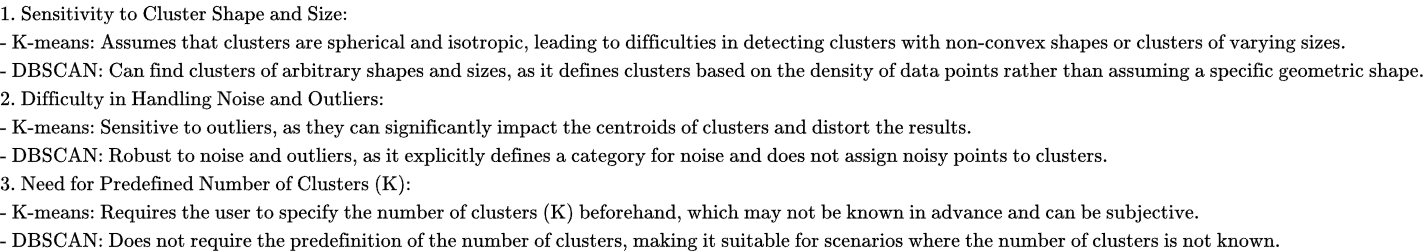
<br>
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together data points that are close to each other in a high-density region and separates data points that lie in low-density regions.

**How to measure density around a point ?**

1. MinPts (Minimum Number of Points): MinPts is the minimum number of data points required to form a dense region or cluster. In other words, for a data point to be considered a "core point," it must have at least MinPts number of data points (including itself) within a specified distance (epsilon or eps).


2. Epsilon (ε) is a key parameter that defines the radius of the neighbourhood around a given data point. Specifically, ε is the maximum distance between two points for them to be considered as part of the same neighbourhood. This parameter is crucial in determining whether points are close enough to be included in a cluster

**Core Points:** A data point is considered a core point if, within its defined neighborhood (specified by epsilon), there are at least MinPts number of data points, including itself.

**Border Points:** A data point is considered a border point if it is within the epsilon neighborhood of a core point but does not have enough data points in its own neighborhood to be a core point.

**Noise Points (Outliers):** A data point is considered a noise point if it is neither a core point nor a border point. These are data points that do not belong to any cluster.

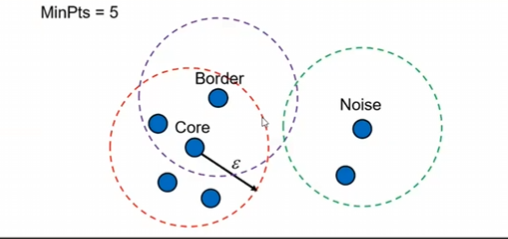

**Directly Density Reachable**

A point P is directly density-reachable from a point Q given Eps, MinPts if:
1. P is in the Eps-neighborhood of Q
2. Both P and Q are core points

In DBSCAN, "Directly Density Reachable" is a concept used to define the connectivity between two data points based on their local density.

**Density Connected Points**

A point P is density connected to Q given Eps, MinPts if there is a chain
of points P1, P2, P3 ...... Pn, P1 = P and Pn = Q such that Pi+1 is directly density reachable from Pi


**DBSCAN Algorithm**

1. Identify all points as either core point, border point, or noise point
<br>
2. For all of the unclustered core points:<br>
   2a. For each unclustered core point, start a new cluster<br>
   2b.  Add all the points that are unclustered and density connected to the current point into this cluster
<br>
3. For each unclustered border point, assign it to the cluster of the nearest core point.
4.  Leave all the noise points as they are - Noise points are not part of any cluster.

**DBSCAN Advantages**: 

1. Robust to outliers
2. No need to specify clusters
3. Can find arbitrary shaped clusters
4. Only 2 hyperparameters to tune

**DBSCAN Disadvantage**:

1. Sensitivity to hyperparameters
2. Difficulty with varying density clusters
3. Does not predict

**When to apply which clustering algorithm ?**

We have above also discussed limitations of kmeans that dbscan solves, 

K-means works well with spherical clusters. If your clusters are globular and have similar sizes, K-means might be a good choice. It assumes that the clusters have similar variance. K-means requires you to specify the number of clusters in advance. If you have a good idea about the number of clusters in your data, K-means can be effective.

DBSCAN is suitable for datasets with irregularly shaped clusters and varying densities. It's effective when clusters are not necessarily spherical or when there is noise in the data.

Hierarchical clustering can be computationally expensive, so it's suitable for smaller to medium-sized datasets.

**Finding the Optimal epsilon value**

Determining the appropriate value for the epsilon parameter in DBSCAN is crucial, as it defines the radius within which points are considered neighbors. One approach to selecting the epsilon value is to use the k-distance plot and identify the "knee" or "elbow" point, where the rate of change in distance starts to decrease. The k-distance plot is often generated using the k-nearest neighbors (KNN) algorithm.

KNN provides information about the proximity or distance of each data point to its k-nearest neighbors. In the k-distance plot, the knee or elbow point corresponds to a threshold beyond which the distances increase at a slower rate. This point is indicative of a transition from dense to sparse regions in the data. Identifying this point helps in determining a suitable epsilon value for DBSCAN.


In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.drop(['CustomerID','Genre'], axis = 1, inplace = True)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

sc=StandardScaler()
scaled_data = sc.fit_transform(df)

In [6]:
kneigbor = NearestNeighbors(n_neighbors = 5) 
neighbor_mall = kneigbor.fit(scaled_data)

In [7]:
distance, indices = neighbor_mall.kneighbors(scaled_data)
distnaces_sort = np.sort(distance,axis=0)

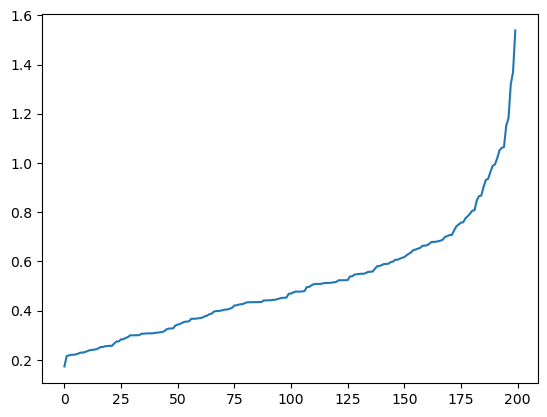

In [9]:
#Plot the distances on the y-axis and the data points sorted by distance on the x-axis.
plt.plot(distnaces_sort[:,4]) 

In [12]:
from sklearn.cluster import DBSCAN
eps_value = [0.6,0.7,0.8,0.9]
min_samples_value = [4,5,6]
result = []
for eps in eps_value:
    for samples in min_samples_value:
        dbscan = DBSCAN(eps=eps,min_samples=samples)
        cluster = dbscan.fit_predict(scaled_data)
        # for which min samples how many no of clusters and how much is the noise
        # usually in kmeans and in Agg clusters will be from 0
        # in dbscan noise points are represented as -1
        n_clusters = len(set(cluster)) - (1 if -1 in cluster else 0)
        n_noise = list(cluster).count(-1)
        result.append((eps,samples,n_clusters,n_noise))


In [13]:
result_data = pd.DataFrame(result, columns=['eps','samples','n clusters','n noise'])
result_data

,eps,samples,n clusters,n noise
0,0.6,4,3,18
1,0.6,5,2,28
2,0.6,6,5,34
3,0.7,4,2,9
4,0.7,5,1,14
5,0.7,6,1,19
6,0.8,4,1,5
7,0.8,5,1,6
8,0.8,6,1,6
9,0.9,4,1,2


In [30]:
final_model = DBSCAN(eps = 0.6, min_samples = 6)
y_cluster = final_model.fit_predict(scaled_data)
df['cluster'] = y_cluster

In [31]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),cluster
0,19,15,39,-1
1,21,15,81,0
2,20,16,6,-1
3,23,16,77,0
4,31,17,40,-1


In [32]:
from sklearn.metrics import silhouette_score
score = silhouette_score(scaled_data,y_cluster)
print(score)

0.0761719083916041


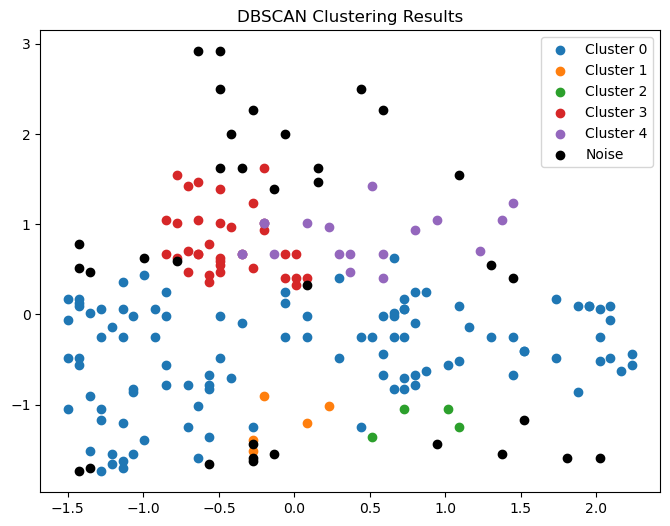

In [33]:
# Visualize the final clusters
plt.figure(figsize=(8, 6))

# Scatter plot for points in each cluster
for cluster_label in set(df['cluster']):
    if cluster_label == -1:
        plt.scatter(scaled_data[df['cluster'] == cluster_label, 0], scaled_data[df['cluster'] == cluster_label, 1], color='black', label='Noise')
    else:
        plt.scatter(scaled_data[df['cluster'] == cluster_label, 0], scaled_data[df['cluster'] == cluster_label, 1], label=f'Cluster {cluster_label}')

plt.title('DBSCAN Clustering Results')
plt.legend()
plt.show()